# **WASTE SEGREGATION USING DEEP LEARNING**

# LOADING THE LIBRARIES

In [ ]:

import tensorflow as tf
import keras
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from keras.callbacks import ModelCheckpoint


DEFINING PARAMETERS

In [ ]:
IMAGE_SIZE = 256
FILE_PATH = '/content/drive/MyDrive/TrashNET'
CHANNELS = 3
BATCH_SIZE =32

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    FILE_PATH,
    image_size = (IMAGE_SIZE ,IMAGE_SIZE),
    shuffle =True ,
    batch_size = BATCH_SIZE,
    seed = 125
)


Found 2527 files belonging to 6 classes.


In [ ]:
class_names = dataset.class_names
num_classes =len(class_names)

print(num_classes)
class_names

6


['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [ ]:
#viewing labels and class of 1st batch  32 images

for image_batch , labels in dataset.take(1):
  print(image_batch.shape)
  print(labels.numpy())
  


(32, 256, 256, 3)
[1 3 2 4 4 4 1 0 1 0 3 4 1 4 2 3 2 0 3 4 4 2 3 0 5 1 2 3 3 3 4 0]


VIEWING IMAGES 

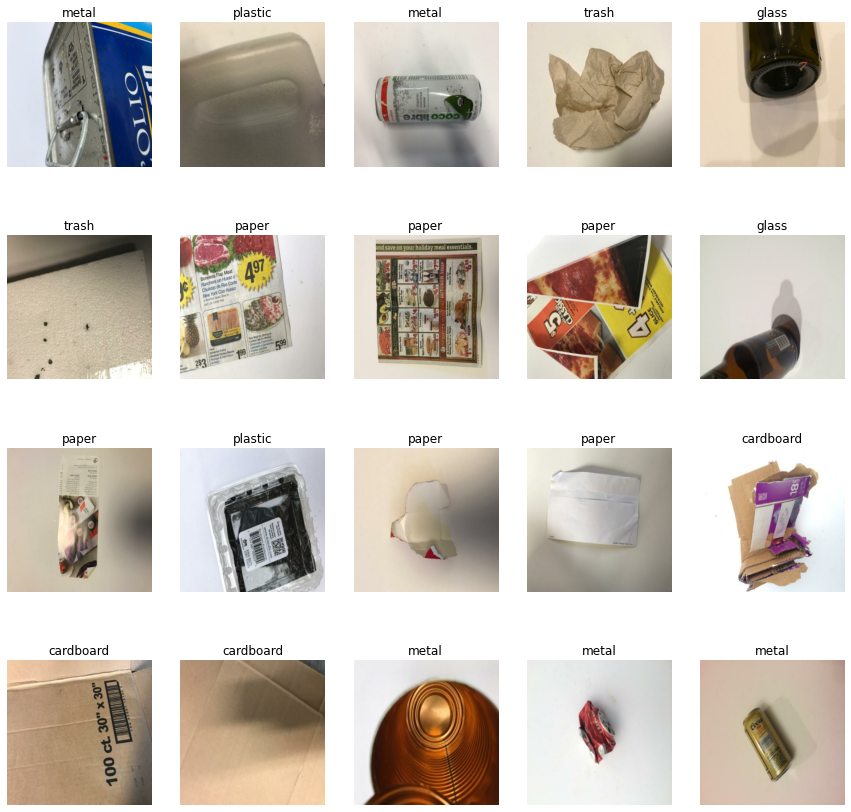

In [ ]:
plt.figure(figsize=(15, 15))
for img ,labels in dataset.take(1):
  for i in range(20):
    plt.subplot(4 ,5, i+1)
    plt.imshow(img[i].numpy().astype('int32'))
    plt.title(class_names[labels[i]])

    plt.axis('off')

SPLITTING DATASET INTO TRAINING TESTING AND VALIDATION

In [ ]:
def split_data(dataset , train_split = 0.7 , test_split = 0.15 , val_split =0.15):
    dataset.shuffle(1000 ,seed = 15)

    dataset_size = len(dataset)
    train_size = int(train_split*dataset_size)
    val_size =int(val_split*dataset_size)
    test_size = int(test_split*dataset_size)

    ##plotting the distribution
    allplots= { "Total_size" : dataset_size ,"Training_size" :train_size ,"Testing_size": test_size ,"Validation_size":val_size}
    print(allplots)
    plt.figure(figsize = (15,6))
    #barplot of all
    plt.subplot(1 , 2,1)
    plt.title('Data Distribution')
    plt.bar(allplots.keys() , allplots.values() ,color= ['r','g','y','m'])

    #pie chart 
    plt.title('Data Distribution')
    plt.subplot(1 , 2,2)
    alldist= {"Training_size" :train_size ,"Testing_size": test_size ,"Validation_size":val_size}
    plt.pie( x= alldist.values() ,labels = alldist.keys() ,autopct ='%.2f' ,colors =['c' ,'g' ,'r' ] ,explode =[0 , 0.01 ,0.1 ])
    
    
    train_data = dataset.take(train_size)
    val_data = dataset.skip(train_size).take(val_size)
    test_data = dataset.skip(train_size + val_size)
    


    return train_data , val_data , test_data



{'Total_size': 79, 'Training_size': 55, 'Testing_size': 11, 'Validation_size': 11}


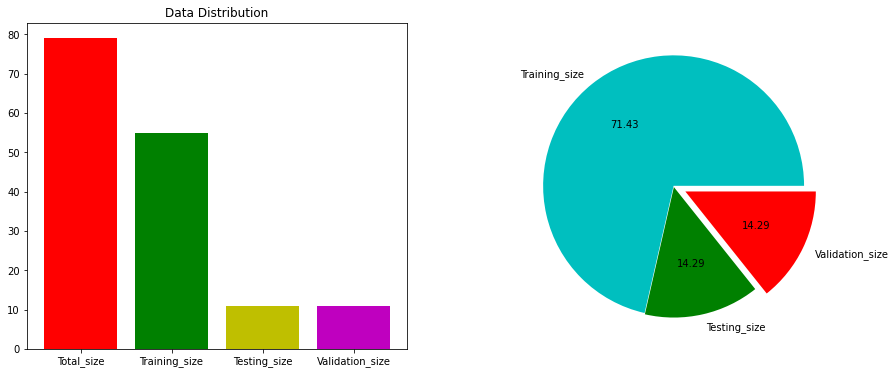

In [ ]:
train_data , val_data , test_data = split_data(dataset)


# MODEL BUILDING

DATA AUGMENTATION

In [ ]:
resize_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE ,IMAGE_SIZE),
    
])

data_augmentation =tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.4),
 
])

VIEWING AUGMENTED IMAGE

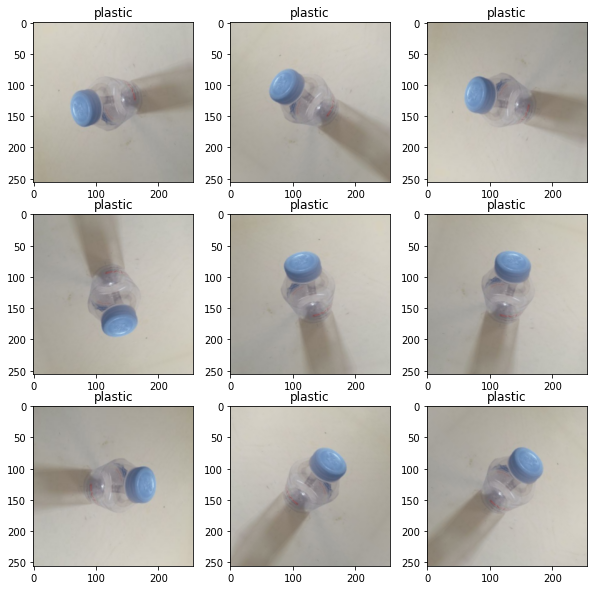

In [ ]:
for img , labels in test_data.take(1):
  plt.figure(figsize=(10, 10))
  img1 =img[0]
  for i in range(9):
    plt.subplot(3,3,i+1)
    augmented_image = data_augmentation(
        tf.expand_dims(img1,0) ,training=True
    )
    plt.imshow(augmented_image[0].numpy().astype('int32'))
    plt.title(class_names[labels[0]])
  

# **MODELS**

# VGG16

In [ ]:
input_shape = (IMAGE_SIZE , IMAGE_SIZE , CHANNELS )


base_model = tf.keras.applications.VGG16(weights ='imagenet' ,include_top = False , input_shape =input_shape)

base_model.trainable =False
inputs = tf.keras.Input(shape = input_shape)

#layers 
x = data_augmentation(inputs)
x = resize_rescale(x)

x= base_model(x , training =False)
x= keras.layers.GlobalAveragePooling2D()(x)
x= keras.layers.Dropout(0.2)(x)
x= tf.keras.layers.Dense(1024, activation='relu')(x)
x= tf.keras.layers.Dense(1024, activation='relu')(x)

outputs = tf.keras.layers.Dense(num_classes, activation = 'softmax')(x)

vgg16_model = tf.keras.Model(inputs ,outputs)


lr = 0.0001
vgg16_model.compile(
    optimizer =keras.optimizers.Adam(learning_rate =0.0001),
    loss = 'sparse_categorical_crossentropy' ,
    metrics =['accuracy']
)


vgg16_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 sequential_3 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d_5   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                           

 TRAINING

In [ ]:
from keras.callbacks import ModelCheckpoint
callback_list = [ModelCheckpoint(filepath = '/content/drive/MyDrive/DL MODELS/vgg16_model.h5' ,monitor='val_accuracy' ,verbose = 1 , save_best_only = True ,mode ='max')]

history = vgg16_model.fit(train_data , 
                          epochs = 100 ,
                          validation_data  = val_data,
                          callbacks = (callback_list))
    


Epoch 1/100
55/55 [==============================] - ETA: 0s - loss: 1.5754 - accuracy: 0.3625
Epoch 1: val_accuracy improved from -inf to 0.42330, saving model to /content/drive/MyDrive/DL MODELS/vgg16_model.h5
55/55 [==============================] - 22s 386ms/step - loss: 1.5754 - accuracy: 0.3625 - val_loss: 1.4430 - val_accuracy: 0.4233
Epoch 2/100
55/55 [==============================] - ETA: 0s - loss: 1.4314 - accuracy: 0.4148
Epoch 2: val_accuracy improved from 0.42330 to 0.51420, saving model to /content/drive/MyDrive/DL MODELS/vgg16_model.h5
55/55 [==============================] - 22s 401ms/step - loss: 1.4314 - accuracy: 0.4148 - val_loss: 1.2718 - val_accuracy: 0.5142
Epoch 3/100
55/55 [==============================] - ETA: 0s - loss: 1.3111 - accuracy: 0.4688
Epoch 3: val_accuracy improved from 0.51420 to 0.54545, saving model to /content/drive/MyDrive/DL MODELS/vgg16_model.h5
55/55 [==============================] - 22s 397ms/step - loss: 1.3111 - accuracy: 0.4688 - va

PLOT OF ACCURACY AND LOSS OF TRAINING AND VALIDATION DATA

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

# VGG16 PLOT

Text(0.5, 0, 'EPOCHS')

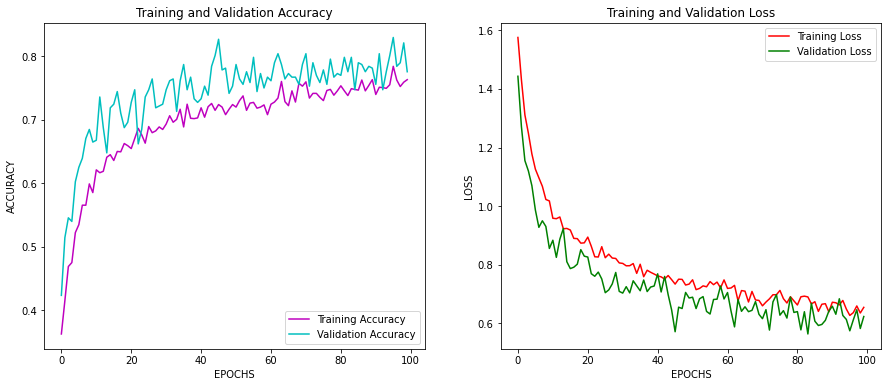

In [ ]:
EPOCHS =100
#MODEL ACCURACY AND LOSS PLOT
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS) ,history.history['accuracy'] ,label = 'Training Accuracy' ,color ='m')
plt.plot(range(EPOCHS) ,history.history['val_accuracy'] ,label = 'Validation Accuracy' ,color ='c')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel('ACCURACY')
plt.xlabel('EPOCHS')


plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), history.history['loss'], label='Training Loss' ,color ='r')
plt.plot(range(EPOCHS), history.history['val_loss'], label='Validation Loss' ,color ='g')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel('LOSS')
plt.xlabel('EPOCHS')

In [ ]:
#importing the best saved model 
vgg16_model = tf.keras.models.load_model('/content/drive/MyDrive/DL MODELS/vgg16_model.h5')

Testing Accuracy

In [ ]:
train_metrics  = vgg16_model.evaluate(train_data)

55/55 [==============================] - 13s 223ms/step - loss: 0.5278 - accuracy: 0.8114


In [ ]:
train_metrics 
print('Accuracy = ' ,train_metrics[1]*100 ,'%')

Accuracy =  81.13636374473572 %


# **PREDICTING THE OUTPUT**

In [ ]:
def predict(model , img):
  img_arr = tf.keras.preprocessing.image.img_to_array(img)
  img_arr = tf.expand_dims(img_arr ,0)

  prediction = model.predict(img_arr)

  predicted_class = class_names[np.argmax(prediction[0])]
  confidence = round(100 *(np.max(prediction[0])),2)

  return predicted_class , confidence


1/1 [==============================] - 0s 17ms/step


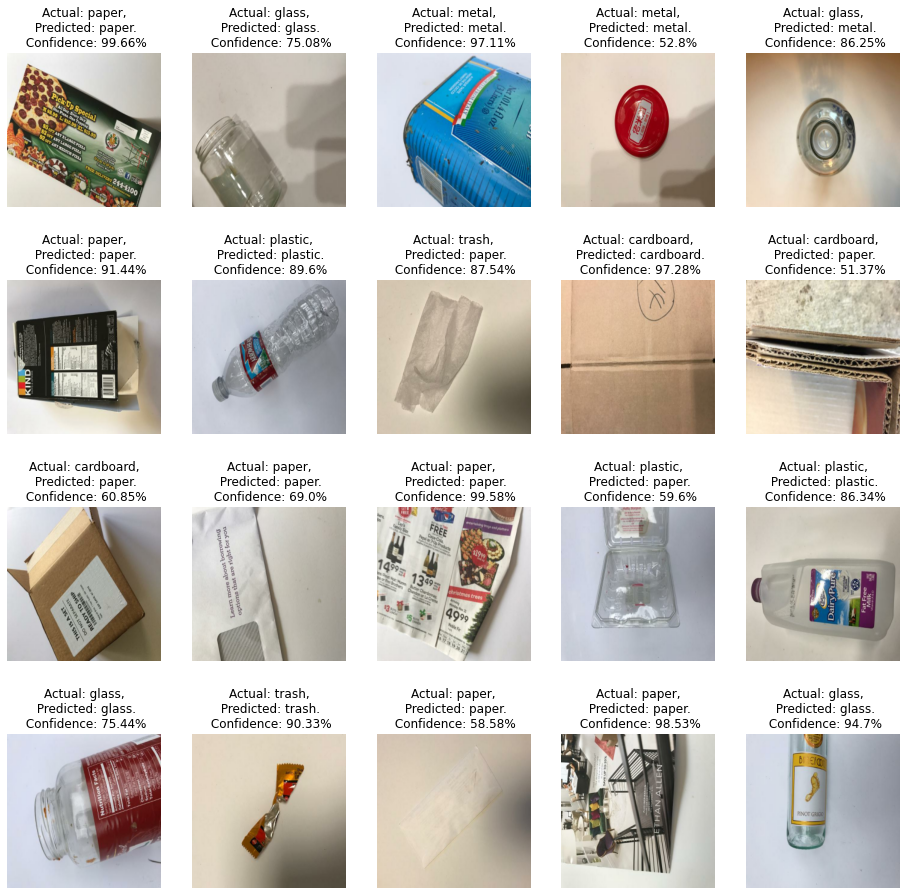

In [ ]:
plt.figure(figsize= (16,16))
for img , labels in test_data.take(1):
  for i in range(20):
    plt.subplot(4,5,i+1)

    predicted_class, confidence = predict(vgg16_model , img[i].numpy())
    plt.imshow(img[i].numpy().astype('int32'))
    actual_class = class_names[labels[i]]
    plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
    plt.axis('off')



In [ ]:
import pickle

In [ ]:
pickle.dump(vgg16_model,open('/content/drive/MyDrive/DL MODELS/vggmodel.pkl', 'wb'))

# RESNET50

In [ ]:
input_shape =(IMAGE_SIZE ,IMAGE_SIZE ,CHANNELS)

base_model = tf.keras.applications.ResNet50(weights = 'imagenet' ,include_top = False ,input_shape = input_shape)
base_model.trainable =False

inputs =tf.keras.Input(shape = input_shape)

x = data_augmentation(inputs)
x = base_model(x, training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1024 , activation = 'relu')(x)
x= tf.keras.layers.Dense(1024, activation='relu')(x)

outputs = tf.keras.layers.Dense(num_classes , activation = 'softmax')(x)

resnet50_model = tf.keras.Model(inputs ,outputs)




resnet50_model.compile(
    optimizer='Adam',
    loss ='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
resnet50_model.summary()



Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 1024)              2098176   
                                                           

In [ ]:
callback_list = [ModelCheckpoint(filepath = '/content/drive/MyDrive/DL MODELS/resnet50_model.h5'  ,monitor ='val_accuracy',verbose = 1 , save_best_only = True ,mode ='max')]


history1 = resnet50_model.fit(train_data ,
                              epochs = 30,
                              validation_data = val_data,
                              callbacks = (callback_list))

Epoch 1/30
55/55 [==============================] - ETA: 0s - loss: 1.0400 - accuracy: 0.6426
Epoch 1: val_accuracy improved from -inf to 0.73011, saving model to /content/drive/MyDrive/DL MODELS/resnet50_model.h5
55/55 [==============================] - 300s 5s/step - loss: 1.0400 - accuracy: 0.6426 - val_loss: 0.6554 - val_accuracy: 0.7301
Epoch 2/30
55/55 [==============================] - ETA: 0s - loss: 0.4971 - accuracy: 0.8216
Epoch 2: val_accuracy improved from 0.73011 to 0.82386, saving model to /content/drive/MyDrive/DL MODELS/resnet50_model.h5
55/55 [==============================] - 18s 323ms/step - loss: 0.4971 - accuracy: 0.8216 - val_loss: 0.4672 - val_accuracy: 0.8239
Epoch 3/30
55/55 [==============================] - ETA: 0s - loss: 0.4610 - accuracy: 0.8267
Epoch 3: val_accuracy improved from 0.82386 to 0.89489, saving model to /content/drive/MyDrive/DL MODELS/resnet50_model.h5
55/55 [==============================] - 18s 327ms/step - loss: 0.4610 - accuracy: 0.8267 

TEST ACCURACY

In [ ]:
resnet50_model.evaluate(test_data)


13/13 [==============================] - 22s 1s/step - loss: 0.5143 - accuracy: 0.8867


[0.5143489837646484, 0.8867470026016235]

In [ ]:
history1.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

# RESNET50 PLOT

Text(0.5, 0, 'EPOCHS')

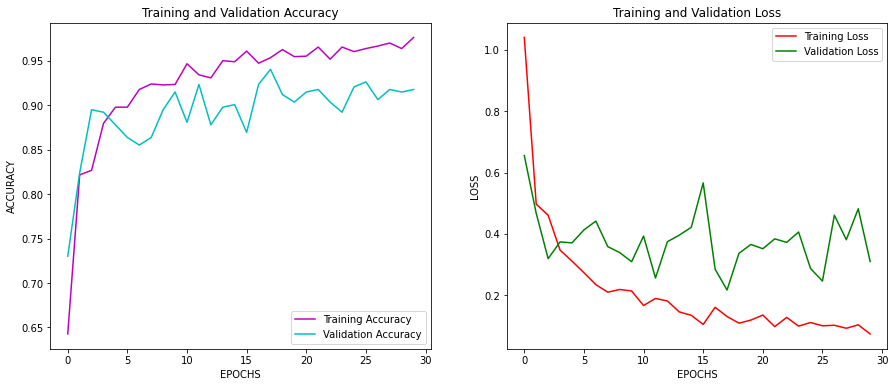

In [ ]:
EPOCHS =30
#MODEL ACCURACY AND LOSS PLOT
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS) ,history1.history['accuracy'] ,label = 'Training Accuracy' ,color ='m')
plt.plot(range(EPOCHS) ,history1.history['val_accuracy'] ,label = 'Validation Accuracy' ,color ='c')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel('ACCURACY')
plt.xlabel('EPOCHS')


plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), history1.history['loss'], label='Training Loss' ,color ='r')
plt.plot(range(EPOCHS), history1.history['val_loss'], label='Validation Loss' ,color ='g')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel('LOSS')
plt.xlabel('EPOCHS')

In [ ]:

def predict(model ,img):
  img_arr = tf.keras.preprocessing.image.img_to_array(img)
  img_arr= tf.expand_dims(img_arr ,0)

  prediction  = model.predict(img_arr)

  predicted_class = class_names[np.argmax(prediction[0])]
  confidence = round(100 *(np.max(prediction[0])),2)

  return predicted_class , confidence





1/1 [==============================] - 0s 22ms/step


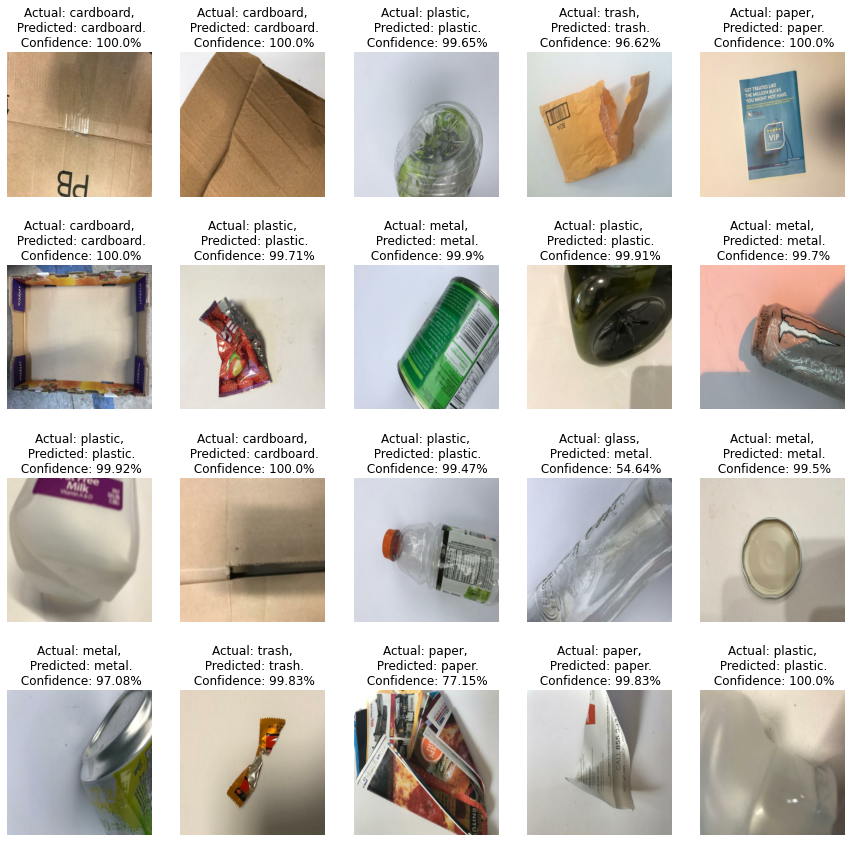

In [ ]:
plt.figure(figsize=(15,15))
for img ,labels in test_data.take(1):
  for i in range(20):

    plt.subplot(4,5,i+1)
    predicted_class, confidence = predict(resnet50_model , img[i].numpy())
    plt.imshow(img[i].numpy().astype('int32'))
    actual_class = class_names[labels[i]]
    plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
    plt.axis('off')
    